In [248]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [249]:
data = pd.read_csv('wine.csv', header = None)

# Naive Bayes Gaussian

In [250]:
# Note: the input to the methods should be pandas dataframes, especially that feature_set has to be 2-d
class NaiveBayesGaussian():
    def __init__(self):
        self.mu_params = None
        self.cov_params = None
        self.pi_params = None
        self.class_labels = None
        
    def fit(self, feature_set, group_set, class_labels):
        complete_set = pd.concat([group_set, feature_set], axis=1)
        sorted_complete_set = pd.merge(pd.DataFrame(class_labels), complete_set, sort=False)
        self.class_labels = class_labels
        self.mu_params = sorted_complete_set.groupby(sorted_complete_set.iloc[:, 0]).mean().iloc[:, 1:]
        self.cov_params = sorted_complete_set.groupby(sorted_complete_set.iloc[:, 0]).var().iloc[:, 1:]
        self.pi_params = sorted_complete_set.groupby(sorted_complete_set.iloc[:, 0]).count().iloc[:, 0] / sorted_complete_set.iloc[:, 0].count()
        
        return self
    
    def predict(self, feature_set, threshold=0.5):
        # use numpy for better performance
        feature_set = np.array(feature_set)
        mu_params = np.array(self.mu_params)
        cov_params = np.array(self.cov_params)
        pi_params = np.array(self.pi_params)
        
        k = len(self.class_labels) # number of classes
        n = feature_set.shape[0] # sample size
        
        # Treat 1d and 2d feature set separately
        if len(feature_set.shape) == 1:
            d = 1
        else:
            d = feature_set.shape[1] # number of features
        
        # for binary classification
        if len(self.class_labels) == 2:
            group_set = np.zeros((n, 1))
            for i in range(n):
                numerator = np.zeros((1, 2))
                likelihood_0 = np.exp(- 0.5 * np.square((feature_set[i] - mu_params[0]) / np.sqrt(cov_params[0]))) / (np.sqrt(2 * np.pi) * np.sqrt(cov_params[0]))
                likelihood_1 = np.exp(- 0.5 * np.square((feature_set[i] - mu_params[1]) / np.sqrt(cov_params[1]))) / (np.sqrt(2 * np.pi) * np.sqrt(cov_params[1]))
                numerator_0 = pi_params[0] * np.prod(likelihood_0)
                numerator_1 = pi_params[1] * np.prod(likelihood_1)
                posterior_0 = numerator_0 / (numerator_0 + numerator_1)
                if posterior_0 > threshold:
                    group_set[i] = self.class_labels[0]
                else:
                    group_set[i] = self.class_labels[1]
        
        # for non-binary classification
        else:
            group_set = np.zeros((n, 1))
            for i in range(n):
                winning_class = 0
                max_prob = 0
                for r in range(k):
                    likelihood = np.exp(- 0.5 * np.square((feature_set[i] - mu_params[r]) / np.sqrt(cov_params[r]))) / (np.sqrt(2 * np.pi) * np.sqrt(cov_params[r]))
                    class_prob = pi_params[r] * np.prod(likelihood)
                    if class_prob > max_prob:
                        winning_class = r
                        max_prob = class_prob
                group_set[i] = self.class_labels[winning_class]
    
        return group_set.ravel().astype(int)

# Linear Discriminant Analysis

In [251]:
# Note: the input to the methods should be pandas dataframes
class LinearDiscriminantAnalysis():
    def __init__(self):
        self.mu_params = None
        self.cov_params = None
        self.pi_params = None
        self.class_labels = None
        
    def fit(self, feature_set, group_set, class_labels):
        complete_set = pd.concat([group_set, feature_set], axis=1)
        sorted_complete_set = pd.merge(pd.DataFrame(class_labels), complete_set, sort=False)
        self.class_labels = class_labels
        self.mu_params = sorted_complete_set.groupby(sorted_complete_set.iloc[:, 0]).mean().iloc[:, 1:]
        self.cov_params = sorted_complete_set.iloc[:, 1:].cov()
        self.pi_params = sorted_complete_set.groupby(sorted_complete_set.iloc[:, 0]).count().iloc[:, 0] / sorted_complete_set.iloc[:, 0].count()
        
        return self
    
    def predict(self, feature_set, threshold=0.5):
        # use numpy for better performance
        feature_set = np.array(feature_set)
        mu_params = np.array(self.mu_params)
        cov_params = np.array(self.cov_params)
        pi_params = np.array(self.pi_params)
        
        k = len(self.class_labels) # number of classes
        n = feature_set.shape[0] # sample size
        
        # Treat 1d and 2d feature set separately
        if len(feature_set.shape) == 1:
            d = 1
        else:
            d = feature_set.shape[1] # number of features
        
        # for binary classification
        if len(self.class_labels) == 2:
            group_set = np.zeros((n, 1))
            for i in range(n):
                numerator = np.zeros((1, 2))
                likelihood_0 = np.exp(- 0.5 * np.linalg.multi_dot([(feature_set[i] - mu_params[0]), np.linalg.inv(cov_params), np.transpose(feature_set[i] - mu_params[0])])) / (np.power(2 * np.pi, d/2) * np.sqrt(np.linalg.det(cov_params)))
                likelihood_1 = np.exp(- 0.5 * np.linalg.multi_dot([(feature_set[i] - mu_params[1]), np.linalg.inv(cov_params), np.transpose(feature_set[i] - mu_params[1])])) / (np.power(2 * np.pi, d/2) * np.sqrt(np.linalg.det(cov_params)))
                numerator_0 = pi_params[0] * likelihood_0
                numerator_1 = pi_params[1] * likelihood_1
                posterior_0 = numerator_0 / (numerator_0 + numerator_1)
                if posterior_0 > threshold:
                    group_set[i] = self.class_labels[0]
                else: 
                    group_set[i] = self.class_labels[1]
        
        # for non-binary classification
        else:
            group_set = np.zeros((n, 1))
            for i in range(n):
                winning_class = 0
                max_prob = 0
                for r in range(k):
                    likelihood = np.exp(- 0.5 * np.linalg.multi_dot([(feature_set[i] - mu_params[r]), np.linalg.inv(cov_params), np.transpose(feature_set[i] - mu_params[r])])) / (np.power(2 * np.pi, d/2) * np.sqrt(np.linalg.det(cov_params)))
                    class_prob = pi_params[r] * likelihood
                    if class_prob > max_prob:
                        winning_class = r
                        max_prob = class_prob
                group_set[i] = self.class_labels[winning_class]
        
        return group_set.ravel().astype(int)
        

# Quadratic Discriminant Analysis

In [252]:
# Note: the input to the methods should be pandas dataframes
class QuadraticDiscriminantAnalysis():
    def __init__(self):
        self.mu_params = None
        self.cov_params = None
        self.pi_params = None
        self.class_labels = None
        
    def fit(self, feature_set, group_set, class_labels):
        complete_set = pd.concat([group_set, feature_set], axis=1)
        sorted_complete_set = pd.merge(pd.DataFrame(class_labels), complete_set, sort=False)
        self.class_labels = class_labels
        self.mu_params = sorted_complete_set.groupby(sorted_complete_set.iloc[:, 0]).mean().iloc[:, 1:]
        cov_params = []
        for i in class_labels:
            cov_class = sorted_complete_set[sorted_complete_set.iloc[:, 0] == i].iloc[:, 1:].cov()
            cov_params.append(cov_class)
        self.cov_params = cov_params
        self.pi_params = sorted_complete_set.groupby(sorted_complete_set.iloc[:, 0]).count().iloc[:, 0] / sorted_complete_set.iloc[:, 0].count()
        
        return self
    
    def predict(self, feature_set, threshold=0.5):
        # use numpy for better performance
        feature_set = np.array(feature_set)
        mu_params = np.array(self.mu_params)
        cov_params = np.array(self.cov_params)
        pi_params = np.array(self.pi_params)
        
        k = len(self.class_labels) # number of classes
        n = feature_set.shape[0] # sample size
        
        # Treat 1d and 2d feature set separately
        if len(feature_set.shape) == 1:
            d = 1
        else:
            d = feature_set.shape[1] # number of features
        
        # for binary classification
        if len(self.class_labels) == 2:
            group_set = np.zeros((n, 1))
            for i in range(n):
                numerator = np.zeros((1, 2))
                likelihood_0 = np.exp(- 0.5 * np.linalg.multi_dot([(feature_set[i] - mu_params[0]), np.linalg.inv(cov_params[0]), np.transpose(feature_set[i] - mu_params[0])])) / (np.power(2 * np.pi, d/2) * np.sqrt(np.linalg.det(cov_params[0])))
                likelihood_1 = np.exp(- 0.5 * np.linalg.multi_dot([(feature_set[i] - mu_params[1]), np.linalg.inv(cov_params[1]), np.transpose(feature_set[i] - mu_params[1])])) / (np.power(2 * np.pi, d/2) * np.sqrt(np.linalg.det(cov_params[1])))
                numerator_0 = pi_params[0] * likelihood_0
                numerator_1 = pi_params[1] * likelihood_1
                posterior_0 = numerator_0 / (numerator_0 + numerator_1)
                if posterior_0 > threshold: # probability threshold for classifying into the first group
                    group_set[i] = self.class_labels[0]
                else: 
                    group_set[i] = self.class_labels[1]
        
        # for non-binary classification
        else:
            group_set = np.zeros((n, 1))
            for i in range(n):
                winning_class = 0
                max_prob = 0
                for r in range(k):
                    likelihood = np.exp(- 0.5 * np.linalg.multi_dot([(feature_set[i] - mu_params[r]), np.linalg.inv(cov_params[r]), np.transpose(feature_set[i] - mu_params[r])])) / (np.power(2 * np.pi, d/2) * np.sqrt(np.linalg.det(cov_params[r])))
                    class_prob = pi_params[r] * likelihood
                    if class_prob > max_prob:
                        winning_class = r
                        max_prob = class_prob
                group_set[i] = self.class_labels[winning_class]
                
        return group_set.ravel().astype(int)
        

# Loss function

In [253]:
def loss(y, y_pred, type_of_loss=None):
    y = np.array(y)
    y_pred = np.array(y_pred)
    if type_of_loss == 'mse':
        loss = (y - y_pred) ** 2 / len(y)
        return loss
    elif type_of_loss == '0-1':
        # binary classification
        # assume that wine type 1 is for positive, type 2 is for negative
        # however, we have to reassign the group numbers if we classify wine type 3
        if len(np.unique(y_pred)) <= 2:
            loss = np.sum(y != y_pred)
            # false positive: true 2 classified as 1
            type_i_error = np.sum(y_pred < y)
            # false negative: true 1 classified as 2
            type_ii_error = np.sum(y < y_pred)
            return loss, type_i_error, type_ii_error
        else:
            loss = np.sum(y != y_pred)
            return loss
    else: 
        message = 'type of error not specified'
        return message

# Visualize the chosen feature

In [254]:
# Select two types of wine
data_1 = data[data.iloc[:, 0].isin([1, 2])]
class_labels = np.array([1, 2])
# Choose one predictor
feature_set = data_1.iloc[:, 1]
group_set = data_1.iloc[:, 0]

<AxesSubplot:>

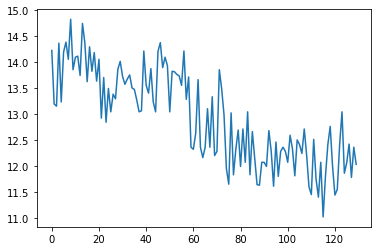

In [255]:
feature_set.plot()

The plot shows that class 2 is relatively low in the amount of feature 1.

# Binary classification with one feature

## LDA: Training error

In [256]:
lda = LinearDiscriminantAnalysis().fit(feature_set, group_set, class_labels)
group_set_pred = lda.predict(feature_set)
result = pd.Series(loss(group_set, group_set_pred, '0-1'), index = ['total_error', 'type_i_error', 'type_ii_error'])
print(result)

total_error      11
type_i_error      4
type_ii_error     7
dtype: int64


## LDA: Classfication result plot

In [257]:
mu_0 = lda.mu_params.iloc[0, 0]
mu_1 = lda.mu_params.iloc[1, 0]
cov = lda.cov_params.iloc[0, 0]
pi_0 = lda.pi_params[1]
pi_1 = lda.pi_params[2]

In [258]:
decision_boundary = 0.5 * (mu_0 + mu_1) - (np.log(pi_0) - np.log(pi_1)) / ((mu_0 - mu_1) / cov)

<function matplotlib.pyplot.show(close=None, block=None)>

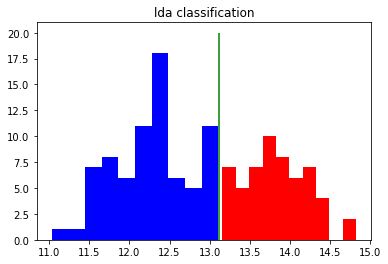

In [259]:
fig = plt.figure()

lda_plot_1 = feature_set
lda_plot_2 = group_set_pred
lda_plot = np.column_stack((lda_plot_1, lda_plot_2))
lda_plot_x1 = lda_plot[lda_plot[:, 1] == 1]
lda_plot_x2 = lda_plot[lda_plot[:, 1] == 2]

zeros1 = np.zeros((len(lda_plot_x1[:, 0]), 1))
zeros2 = np.zeros((len(lda_plot_x2[:, 0]), 1))
plt.hist(lda_plot_x1[:, 0], color='red')
plt.hist(lda_plot_x2[:, 0], color='blue')
plt.vlines(decision_boundary, 0, 20, color='green')

plt.title('lda classification')
plt.show

## LDA: LOOCV error

In [260]:
import math

In [261]:
n_train = data_1.shape[0]
num_fold = n_train
n_fold = math.floor(n_train / num_fold)

total_error = 0
type_i_error = 0
type_ii_error = 0
for cur_fold in range(num_fold):
    feature_set_fold = feature_set.iloc[cur_fold * n_fold : (cur_fold + 1) * n_fold]
    group_set_fold = group_set.iloc[cur_fold * n_fold : (cur_fold + 1) * n_fold]
    feature_set_train_fold = feature_set.iloc[np.r_[0 : cur_fold * n_fold, (cur_fold + 1) * n_fold : n_train]]
    group_set_train_fold = group_set.iloc[np.r_[0 : cur_fold * n_fold, (cur_fold + 1) * n_fold : n_train]]
        
    pr = LinearDiscriminantAnalysis().fit(feature_set_train_fold, group_set_train_fold, class_labels)
    group_set_pred = pr.predict(feature_set_fold)
    total_error += loss(group_set_fold, group_set_pred, '0-1')[0]
    type_i_error += loss(group_set_fold, group_set_pred, '0-1')[1]
    type_ii_error += loss(group_set_fold, group_set_pred, '0-1')[2]

result = pd.Series([total_error, type_i_error, type_ii_error], index = ['total_error', 'type_i_error', 'type_ii_error'])
print(result)

total_error      12
type_i_error      5
type_ii_error     7
dtype: int64


## QDA: Training error

In [262]:
qda = QuadraticDiscriminantAnalysis().fit(feature_set, group_set, class_labels)
group_set_pred = qda.predict(feature_set)
result = pd.Series(loss(group_set, group_set_pred, '0-1'), index = ['total_error', 'type_i_error', 'type_ii_error'])
print(result)

total_error      12
type_i_error      5
type_ii_error     7
dtype: int64


## QDA: Classification result plot

<function matplotlib.pyplot.show(close=None, block=None)>

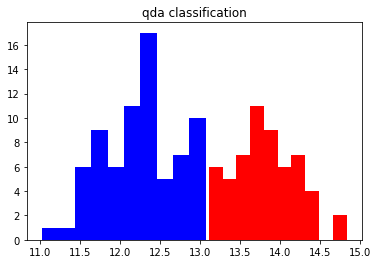

In [267]:
fig = plt.figure()

qda_plot_1 = feature_set
qda_plot_2 = group_set_pred
qda_plot = np.column_stack((qda_plot_1, qda_plot_2))
qda_plot_x1 = qda_plot[qda_plot[:, 1] == 1]
qda_plot_x2 = qda_plot[qda_plot[:, 1] == 2]

zeros1 = np.zeros((len(qda_plot_x1[:, 0]), 1))
zeros2 = np.zeros((len(qda_plot_x2[:, 0]), 1))
plt.hist(qda_plot_x1[:, 0], color='red')
plt.hist(qda_plot_x2[:, 0], color='blue')

plt.title('qda classification')
plt.show

## QDA: LOOCV error

In [182]:
n_train = data_1.shape[0]
num_fold = n_train
n_fold = math.floor(n_train / num_fold)

total_error = 0
type_i_error = 0
type_ii_error = 0
for cur_fold in range(num_fold):
    feature_set_fold = feature_set.iloc[cur_fold * n_fold : (cur_fold + 1) * n_fold]
    group_set_fold = group_set.iloc[cur_fold * n_fold : (cur_fold + 1) * n_fold]
    feature_set_train_fold = feature_set.iloc[np.r_[0 : cur_fold * n_fold, (cur_fold + 1) * n_fold : n_train]]
    group_set_train_fold = group_set.iloc[np.r_[0 : cur_fold * n_fold, (cur_fold + 1) * n_fold : n_train]]
        
    pr = QuadraticDiscriminantAnalysis().fit(feature_set_train_fold, group_set_train_fold, class_labels)
    group_set_pred = pr.predict(feature_set_fold)
    total_error += loss(group_set_fold, group_set_pred, '0-1')[0]
    type_i_error += loss(group_set_fold, group_set_pred, '0-1')[1]
    type_ii_error += loss(group_set_fold, group_set_pred, '0-1')[2]

result = pd.Series([total_error, type_i_error, type_ii_error], index = ['total_error', 'type_i_error', 'type_ii_error'])
print(result)

total_error      12
type_i_error      5
type_ii_error     7
dtype: int64


## NBG: Training error

In [183]:
nbg = NaiveBayesGaussian().fit(feature_set, group_set, class_labels)
group_set_pred = nbg.predict(feature_set)
result = pd.Series(loss(group_set, group_set_pred, '0-1'), index = ['total_error', 'type_i_error', 'type_ii_error'])
print(result)

total_error      12
type_i_error      5
type_ii_error     7
dtype: int64


## NBG: Classification result plot

<function matplotlib.pyplot.show(close=None, block=None)>

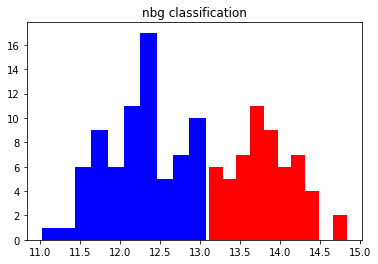

In [268]:
fig = plt.figure()

nbg_plot_1 = feature_set
nbg_plot_2 = group_set_pred
nbg_plot = np.column_stack((nbg_plot_1, nbg_plot_2))
nbg_plot_x1 = nbg_plot[nbg_plot[:, 1] == 1]
nbg_plot_x2 = nbg_plot[nbg_plot[:, 1] == 2]

zeros1 = np.zeros((len(nbg_plot_x1[:, 0]), 1))
zeros2 = np.zeros((len(nbg_plot_x2[:, 0]), 1))
plt.hist(nbg_plot_x1[:, 0], color='red')
plt.hist(nbg_plot_x2[:, 0], color='blue')

plt.title('nbg classification')
plt.show

## NBG: LOOCV error

In [184]:
n_train = data_1.shape[0]
num_fold = n_train
n_fold = math.floor(n_train / num_fold)

total_error = 0
type_i_error = 0
type_ii_error = 0
for cur_fold in range(num_fold):
    feature_set_fold = feature_set.iloc[cur_fold * n_fold : (cur_fold + 1) * n_fold]
    group_set_fold = group_set.iloc[cur_fold * n_fold : (cur_fold + 1) * n_fold]
    feature_set_train_fold = feature_set.iloc[np.r_[0 : cur_fold * n_fold, (cur_fold + 1) * n_fold : n_train]]
    group_set_train_fold = group_set.iloc[np.r_[0 : cur_fold * n_fold, (cur_fold + 1) * n_fold : n_train]]
        
    pr = NaiveBayesGaussian().fit(feature_set_train_fold, group_set_train_fold, class_labels)
    group_set_pred = pr.predict(feature_set_fold)
    total_error += loss(group_set_fold, group_set_pred, '0-1')[0]
    type_i_error += loss(group_set_fold, group_set_pred, '0-1')[1]
    type_ii_error += loss(group_set_fold, group_set_pred, '0-1')[2]

result = pd.Series([total_error, type_i_error, type_ii_error], index = ['total_error', 'type_i_error', 'type_ii_error'])
print(result)

total_error      12
type_i_error      5
type_ii_error     7
dtype: int64


## Performance of the classifiers

We can't observe too much difference among the classifiers. I think the performance in general is not bad, because the sample size is over 120, and there are just over 10 which are miss classified.

# Binary classification with 2 features

In [198]:
# Select two types of wine
data_1 = data[data.iloc[:, 0].isin([1, 2])]
class_labels = np.array([1, 2])
# Choose one predictor
feature_set = data_1.iloc[:, 1 : 3]
group_set = data_1.iloc[:, 0]

## LDA: Training error

In [199]:
lda = LinearDiscriminantAnalysis().fit(feature_set, group_set, class_labels)
group_set_pred = lda.predict(feature_set)
result = pd.Series(loss(group_set, group_set_pred, '0-1'), index = ['total_error', 'type_i_error', 'type_ii_error'])
print(result)

total_error      59
type_i_error      0
type_ii_error    59
dtype: int64


## ROC curve

In [224]:
meshgrid = np.linspace(0, 1, num = 1000)

In [225]:
# total class 1 items
total_positive = data_1.groupby(data_1.iloc[:, 0]).count().iloc[0, 0]
# total class 2 items
total_negative = data_1.groupby(data_1.iloc[:, 0]).count().iloc[1, 0]

In [226]:
true_positive_rate_all = []
false_positive_rate_all = []
for threshold in meshgrid:
    group_set_pred = lda.predict(feature_set, threshold)
    type_i_error = loss(group_set, group_set_pred, '0-1')[1] # true 2 classified as 1
    type_ii_error = loss(group_set, group_set_pred, '0-1')[2] # true 1 classified as 2
    true_positive_rate = (total_positive - type_ii_error) / total_positive
    false_positive_rate = type_i_error / total_negative
    true_positive_rate_all.append(true_positive_rate)
    false_positive_rate_all.append(false_positive_rate)

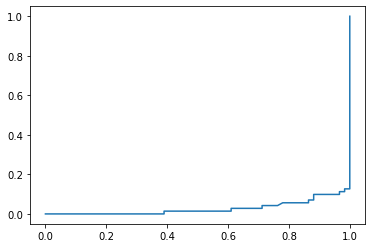

In [227]:
plt.plot(true_positive_rate_all, false_positive_rate_all, 1, 1)

In [229]:
# Area under the curve
area = 0
for i in range(len(meshgrid) - 1):
    area += (true_positive_rate_all[i+1] - true_positive_rate_all[i]) * (false_positive_rate_all[i+1] - false_positive_rate_all[i])
    
area = 1 - area
area_under_the_curve = (area + 1) / 2

In [230]:
area_under_the_curve

0.9998806397708284

## LDA: LOOCV error

In [89]:
n_train = data_1.shape[0]
num_fold = n_train
n_fold = math.floor(n_train / num_fold)

total_error = 0
type_i_error = 0
type_ii_error = 0
for cur_fold in range(num_fold):
    feature_set_fold = feature_set.iloc[cur_fold * n_fold : (cur_fold + 1) * n_fold]
    group_set_fold = group_set.iloc[cur_fold * n_fold : (cur_fold + 1) * n_fold]
    feature_set_train_fold = feature_set.iloc[np.r_[0 : cur_fold * n_fold, (cur_fold + 1) * n_fold : n_train]]
    group_set_train_fold = group_set.iloc[np.r_[0 : cur_fold * n_fold, (cur_fold + 1) * n_fold : n_train]]
        
    pr = LinearDiscriminantAnalysis().fit(feature_set_train_fold, group_set_train_fold, class_labels)
    group_set_pred = pr.predict(feature_set_fold)
    total_error += loss(group_set_fold, group_set_pred, '0-1')[0]
    type_i_error += loss(group_set_fold, group_set_pred, '0-1')[1]
    type_ii_error += loss(group_set_fold, group_set_pred, '0-1')[2]

result = pd.Series([total_error, type_i_error, type_ii_error], index = ['total_error', 'type_i_error', 'type_ii_error'])
print(result)

total_error      13
type_i_error      7
type_ii_error     6
dtype: int64


## QDA: Training error

In [214]:
qda = QuadraticDiscriminantAnalysis().fit(feature_set, group_set, class_labels)
group_set_pred = qda.predict(feature_set)
result = pd.Series(loss(group_set, group_set_pred, '0-1'), index = ['total_error', 'type_i_error', 'type_ii_error'])
print(result)

total_error      7
type_i_error     4
type_ii_error    3
dtype: int64


## QDA: ROC curve

In [231]:
true_positive_rate_all = []
false_positive_rate_all = []
for threshold in meshgrid:
    group_set_pred = qda.predict(feature_set, threshold)
    type_i_error = loss(group_set, group_set_pred, '0-1')[1] # true 2 classified as 1
    type_ii_error = loss(group_set, group_set_pred, '0-1')[2] # true 1 classified as 2
    true_positive_rate = (total_positive - type_ii_error) / total_positive
    false_positive_rate = type_i_error / total_negative
    true_positive_rate_all.append(true_positive_rate)
    false_positive_rate_all.append(false_positive_rate)

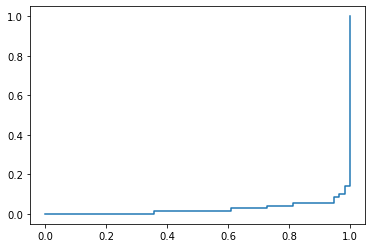

In [232]:
plt.plot(true_positive_rate_all, false_positive_rate_all, 1, 1)

In [233]:
# Area under the curve
area = 0
for i in range(len(meshgrid) - 1):
    area += (true_positive_rate_all[i+1] - true_positive_rate_all[i]) * (false_positive_rate_all[i+1] - false_positive_rate_all[i])
    
area = 1 - area
area_under_the_curve = (area + 1) / 2

In [234]:
area_under_the_curve

1.0

## QDA: LOOCV error

In [91]:
n_train = data_1.shape[0]
num_fold = n_train
n_fold = math.floor(n_train / num_fold)

total_error = 0
type_i_error = 0
type_ii_error = 0
for cur_fold in range(num_fold):
    feature_set_fold = feature_set.iloc[cur_fold * n_fold : (cur_fold + 1) * n_fold]
    group_set_fold = group_set.iloc[cur_fold * n_fold : (cur_fold + 1) * n_fold]
    feature_set_train_fold = feature_set.iloc[np.r_[0 : cur_fold * n_fold, (cur_fold + 1) * n_fold : n_train]]
    group_set_train_fold = group_set.iloc[np.r_[0 : cur_fold * n_fold, (cur_fold + 1) * n_fold : n_train]]
        
    pr = QuadraticDiscriminantAnalysis().fit(feature_set_train_fold, group_set_train_fold, class_labels)
    group_set_pred = pr.predict(feature_set_fold)
    total_error += loss(group_set_fold, group_set_pred, '0-1')[0]
    type_i_error += loss(group_set_fold, group_set_pred, '0-1')[1]
    type_ii_error += loss(group_set_fold, group_set_pred, '0-1')[2]

result = pd.Series([total_error, type_i_error, type_ii_error], index = ['total_error', 'type_i_error', 'type_ii_error'])
print(result)

total_error      7
type_i_error     3
type_ii_error    4
dtype: int64


## NBG: Training error

In [221]:
nbg = NaiveBayesGaussian().fit(feature_set, group_set, class_labels)
group_set_pred = nbg.predict(feature_set)
result = pd.Series(loss(group_set, group_set_pred, '0-1'), index = ['total_error', 'type_i_error', 'type_ii_error'])
print(result)

total_error      7
type_i_error     4
type_ii_error    3
dtype: int64


## NBG: ROC curve

In [235]:
true_positive_rate_all = []
false_positive_rate_all = []
for threshold in meshgrid:
    group_set_pred = nbg.predict(feature_set, threshold)
    type_i_error = loss(group_set, group_set_pred, '0-1')[1] # true 2 classified as 1
    type_ii_error = loss(group_set, group_set_pred, '0-1')[2] # true 1 classified as 2
    true_positive_rate = (total_positive - type_ii_error) / total_positive
    false_positive_rate = type_i_error / total_negative
    true_positive_rate_all.append(true_positive_rate)
    false_positive_rate_all.append(false_positive_rate)

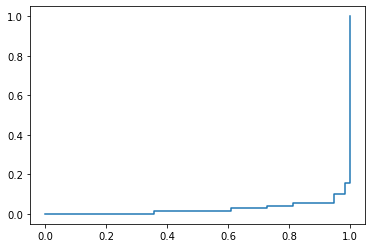

In [236]:
plt.plot(true_positive_rate_all, false_positive_rate_all, 1, 1)

In [237]:
# Area under the curve
area = 0
for i in range(len(meshgrid) - 1):
    area += (true_positive_rate_all[i+1] - true_positive_rate_all[i]) * (false_positive_rate_all[i+1] - false_positive_rate_all[i])
    
area = 1 - area
area_under_the_curve = (area + 1) / 2

In [238]:
area_under_the_curve

1.0

## NBG: LOOCV error

In [93]:
n_train = data_1.shape[0]
num_fold = n_train
n_fold = math.floor(n_train / num_fold)

total_error = 0
type_i_error = 0
type_ii_error = 0
for cur_fold in range(num_fold):
    feature_set_fold = feature_set.iloc[cur_fold * n_fold : (cur_fold + 1) * n_fold]
    group_set_fold = group_set.iloc[cur_fold * n_fold : (cur_fold + 1) * n_fold]
    feature_set_train_fold = feature_set.iloc[np.r_[0 : cur_fold * n_fold, (cur_fold + 1) * n_fold : n_train]]
    group_set_train_fold = group_set.iloc[np.r_[0 : cur_fold * n_fold, (cur_fold + 1) * n_fold : n_train]]
        
    pr = NaiveBayesGaussian().fit(feature_set_train_fold, group_set_train_fold, class_labels)
    group_set_pred = pr.predict(feature_set_fold)
    total_error += loss(group_set_fold, group_set_pred, '0-1')[0]
    type_i_error += loss(group_set_fold, group_set_pred, '0-1')[1]
    type_ii_error += loss(group_set_fold, group_set_pred, '0-1')[2]

result = pd.Series([total_error, type_i_error, type_ii_error], index = ['total_error', 'type_i_error', 'type_ii_error'])
print(result)

total_error      8
type_i_error     3
type_ii_error    5
dtype: int64


# 3-Classes classification with many features

In [103]:
group_set = data.iloc[:, 0]
feature_set = data.iloc[:, 1:]
class_labels = group_set.unique()

## LDA: Training error

In [104]:
lda = LinearDiscriminantAnalysis().fit(feature_set, group_set, class_labels)
group_set_pred = lda.predict(feature_set)
result = pd.Series(loss(group_set, group_set_pred, '0-1'), index = ['total_error', 'type_i_error', 'type_ii_error'])
print(result)

total_error      0
type_i_error     0
type_ii_error    0
dtype: int32


## LDA: LOOCV error

In [106]:
n_train = data.shape[0]
num_fold = n_train
n_fold = math.floor(n_train / num_fold)

total_error = 0
type_i_error = 0
type_ii_error = 0
for cur_fold in range(num_fold):
    feature_set_fold = feature_set.iloc[cur_fold * n_fold : (cur_fold + 1) * n_fold]
    group_set_fold = group_set.iloc[cur_fold * n_fold : (cur_fold + 1) * n_fold]
    feature_set_train_fold = feature_set.iloc[np.r_[0 : cur_fold * n_fold, (cur_fold + 1) * n_fold : n_train]]
    group_set_train_fold = group_set.iloc[np.r_[0 : cur_fold * n_fold, (cur_fold + 1) * n_fold : n_train]]
        
    pr = LinearDiscriminantAnalysis().fit(feature_set_train_fold, group_set_train_fold, class_labels)
    group_set_pred = pr.predict(feature_set_fold)
    total_error += loss(group_set_fold, group_set_pred, '0-1')[0]
    type_i_error += loss(group_set_fold, group_set_pred, '0-1')[1]
    type_ii_error += loss(group_set_fold, group_set_pred, '0-1')[2]

result = pd.Series([total_error, type_i_error, type_ii_error], index = ['total_error', 'type_i_error', 'type_ii_error'])
print(result)

total_error      1
type_i_error     0
type_ii_error    1
dtype: int64


## QDA: Training error

In [107]:
qda = QuadraticDiscriminantAnalysis().fit(feature_set, group_set, class_labels)
group_set_pred = qda.predict(feature_set)
result = pd.Series(loss(group_set, group_set_pred, '0-1'), index = ['total_error', 'type_i_error', 'type_ii_error'])
print(result)

total_error      1
type_i_error     1
type_ii_error    1
dtype: int32


## QDA: LOOCV error

In [99]:
n_train = data.shape[0]
num_fold = n_train
n_fold = math.floor(n_train / num_fold)

total_error = 0
type_i_error = 0
type_ii_error = 0
for cur_fold in range(num_fold):
    feature_set_fold = feature_set.iloc[cur_fold * n_fold : (cur_fold + 1) * n_fold]
    group_set_fold = group_set.iloc[cur_fold * n_fold : (cur_fold + 1) * n_fold]
    feature_set_train_fold = feature_set.iloc[np.r_[0 : cur_fold * n_fold, (cur_fold + 1) * n_fold : n_train]]
    group_set_train_fold = group_set.iloc[np.r_[0 : cur_fold * n_fold, (cur_fold + 1) * n_fold : n_train]]
        
    pr = QuadraticDiscriminantAnalysis().fit(feature_set_train_fold, group_set_train_fold, class_labels)
    group_set_pred = pr.predict(feature_set_fold)
    total_error += loss(group_set_fold, group_set_pred, '0-1')[0]
    type_i_error += loss(group_set_fold, group_set_pred, '0-1')[1]
    type_ii_error += loss(group_set_fold, group_set_pred, '0-1')[2]

result = pd.Series([total_error, type_i_error, type_ii_error], index = ['total_error', 'type_i_error', 'type_ii_error'])
print(result)

total_error      1
type_i_error     0
type_ii_error    1
dtype: int64
